In [1]:
import os
import sys
import json
import shutil
import numpy as np
import pandas as pd

In [2]:
# Helper function
def writeProgress(msg, count, total):
    sys.stdout.write(msg + "{:.2%}\r".format(count/total))
    sys.stdout.flush()
    
def newPath(path):
    if not os.path.isdir(path):
        os.mkdir(path)

def read_json(src_path):
    with open(src_path, 'r') as json_file:
        data = json.load(json_file)
    return data

def write_json(data,dst_path):
    with open(dst_path, 'w') as outfile:
        json.dump(data, outfile)

In [3]:
columns = read_json('../../orderedListGenres.json')
print(len(columns), columns)

20 ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Mystery', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western']


In [4]:
# 模型輸出儲存的檔案
SAVE_NAME = 'resnet50_trainable_8e-5_starwars'
HISTORY_SAVE = './history/' + SAVE_NAME + '.csv'
WEIGHTS_SAVE = './weight/' + SAVE_NAME + '.h5'

# ResNet50 Model

In [5]:
# read dataframe
train_df = pd.read_csv('../filename2genreMat.csv')
test_df = pd.read_csv('../poster2genreMat.csv')
print(train_df.shape, test_df.shape)

(37959, 22) (165, 22)


In [6]:
valid_df = train_df.sample(frac = 0.2, random_state = 42)
train_df = train_df.drop(valid_df.index)
print(train_df.shape, valid_df.shape)

(30367, 22) (7592, 22)


In [7]:
from keras.applications import ResNet50
from keras import models
from keras.models import Model
from keras.optimizers import Adam
from keras_preprocessing.image import ImageDataGenerator
from keras import layers
from keras import regularizers, optimizers
# from keras.applications.model import ResNet152

Using TensorFlow backend.


In [8]:
# 資料路徑
DATASET_PATH  = '../IGimg'

# 影像大小
IMAGE_SIZE = (224, 224)

# 影像類別數
NUM_CLASSES = 20

# 若 GPU 記憶體不足，可調降 batch size 或凍結更多層網路
BATCH_SIZE = 32

# Epoch 數
NUM_EPOCHS = 100

In [9]:
datagen=ImageDataGenerator(rescale=1./255.)
test_datagen=ImageDataGenerator(rescale=1./255.)

train_generator=datagen.flow_from_dataframe(dataframe=train_df,
                                            directory=DATASET_PATH,
                                            x_col="filename",
                                            y_col=columns,
                                            batch_size=BATCH_SIZE,
                                            seed=42,
                                            shuffle=True,
                                            class_mode="other",
                                            target_size=IMAGE_SIZE)

valid_generator=test_datagen.flow_from_dataframe(dataframe=valid_df,
                                                 directory=DATASET_PATH,
                                                 x_col="filename",
                                                 y_col=columns,
                                                 batch_size=BATCH_SIZE,
                                                 seed=42,
                                                 shuffle=True,
                                                 class_mode="other",
                                                 target_size=IMAGE_SIZE)

Found 30367 validated image filenames.
Found 7592 validated image filenames.


# Fixed the last Layer from 1000 classes into N classes

In [10]:
conv_base = ResNet50(weights='imagenet',
                  include_top=False,
                  input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3))
conv_base.summary()

Instructions for updating:
Colocations handled automatically by placer.


/home/tonylab/.local/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [11]:
model = models.Sequential()
model.add(conv_base)        # 將卷積基底視為層加入 Sequential 模型中
model.add(layers.AveragePooling2D(pool_size=(7, 7)))
model.add(layers.Flatten()) # 攤平
model.add(layers.Dense(NUM_CLASSES, activation='sigmoid')) # 增加密集層分類器
model.summary() # 查看模型摘要

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
average_pooling2d_1 (Average (None, 1, 1, 2048)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                40980     
Total params: 23,628,692
Trainable params: 23,575,572
Non-trainable params: 53,120
_________________________________________________________________


In [12]:
print('This is the number of trainable weights before freezing the conv base:', len(model.trainable_weights))

conv_base.trainable = True

print('This is the number of trainable weights after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 214
This is the number of trainable weights after freezing the conv base: 214


In [13]:
model.compile(optimizer=Adam(lr=8e-5),
              loss='binary_crossentropy',
              metrics=['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
average_pooling2d_1 (Average (None, 1, 1, 2048)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                40980     
Total params: 23,628,692
Trainable params: 23,575,572
Non-trainable params: 53,120
_________________________________________________________________


# Training Model

In [14]:
STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size

In [15]:
# 訓練模型
from keras.callbacks import EarlyStopping
callbacks = [EarlyStopping(monitor='val_loss')]

history = model.fit_generator(generator = train_generator,
                              steps_per_epoch = STEP_SIZE_TRAIN,
                              validation_data = valid_generator,
                              validation_steps = STEP_SIZE_VALID,
                              epochs = NUM_EPOCHS,
                              callbacks=callbacks)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
948/948 [==============================] - 267s 281ms/step - loss: 0.2326 - acc: 0.9068 - val_loss: 0.2285 - val_acc: 0.9097
Epoch 2/100
948/948 [==============================] - 266s 280ms/step - loss: 0.1513 - acc: 0.9405 - val_loss: 0.1639 - val_acc: 0.9300
Epoch 3/100
948/948 [==============================] - 266s 280ms/step - loss: 0.0957 - acc: 0.9637 - val_loss: 0.2590 - val_acc: 0.9306


In [16]:
# 儲存訓練好的模型
model.save(WEIGHTS_SAVE)

In [17]:
# save history
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

his_df = pd.DataFrame(data = {
    'Epoch' : epochs,
    'Loss' : loss,
    'Acc' : acc,
    'Val_loss' : val_loss,
    'Val_acc' : val_acc
})
his_df = his_df[['Epoch', 'Loss', 'Acc', 'Val_loss', 'Val_acc']]
his_df.to_csv(HISTORY_SAVE, index = False)

# Plot acc & loss

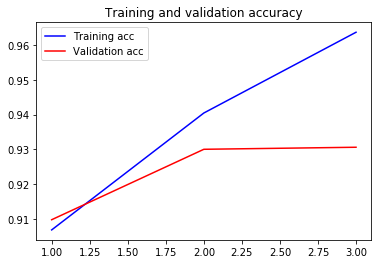

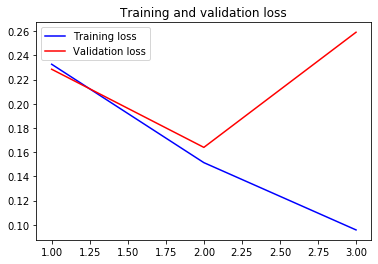

In [18]:
# 繪製結果
import matplotlib.pyplot as plt

plt.figure()

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Testing

### Testing set: Poster

In [19]:
SAVE_NAME = SAVE_NAME + '_poster'

In [20]:
test_df = pd.read_csv('../poster2genreMat.csv')
test_df

,from,filename,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,...,History,Horror,Music,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
0,../Profiles_165/21bridgesmovie/poster.jpeg,21bridgesmovie.jpg,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
1,../Profiles_165/47metersdown/poster.jpeg,47metersdown.jpg,0,1,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
2,../Profiles_165/abeautifuldaymovie/poster.jpeg,abeautifuldaymovie.jpg,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,../Profiles_165/abominablemovie/poster.jpeg,abominablemovie.jpg,0,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,../Profiles_165/adastramovie/poster.jpeg,adastramovie.jpg,0,1,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,../Profiles_165/wrinklestheclown/poster.jpeg,wrinklestheclown.jpg,0,0,0,0,1,0,1,0,...,0,1,0,0,0,0,0,0,0,0
161,../Profiles_165/xmenmovies/poster.jpeg,xmenmovies.jpg,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
162,../Profiles_165/yardiefilm/poster.jpeg,yardiefilm.jpg,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
163,../Profiles_165/yesterdaymovie/poster.jpeg,yesterdaymovie.jpg,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [21]:
DATASET_PATH = '../Poster'

In [22]:
test_generator=test_datagen.flow_from_dataframe(dataframe=test_df,
                                                directory=DATASET_PATH,
                                                x_col="filename",
                                                batch_size=1,
                                                seed=42,
                                                shuffle=False,
                                                class_mode=None,
                                                target_size=IMAGE_SIZE)

Found 165 validated image filenames.


In [23]:
STEP_SIZE_TEST = test_generator.n // test_generator.batch_size

In [24]:
test_generator.reset()
pred=model.predict_generator(test_generator,
                                     steps=STEP_SIZE_TEST,
                                     verbose=1)

165/165 [==============================] - 11s 68ms/step


# Output

In [25]:
pred.shape

(165, 20)

In [26]:
predictions = pred

results=pd.DataFrame(predictions, columns=columns)
results["filename"] = test_generator.filenames
ordered_cols = ["filename"] + columns
results = results[ordered_cols] #To get the same column order
results.to_csv("./output/"+ SAVE_NAME + "_result.csv",index=False)

## Label top n dynamic

In [27]:
true_df = test_df

In [28]:
results = pd.read_csv("./output/"+ SAVE_NAME + "_result.csv")
results

,filename,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,...,History,Horror,Music,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
0,21bridgesmovie.jpg,0.507658,0.010004,0.000469,0.211312,0.341836,0.952402,0.001468,0.703031,0.000239,...,0.101483,0.007028,0.000827,0.005320,0.010000,0.032142,0.001253,0.261539,0.014926,0.001298
1,47metersdown.jpg,0.291905,0.638116,0.008410,0.023131,0.045406,0.017468,0.002783,0.519937,0.005204,...,0.005208,0.108149,0.005764,0.046697,0.014660,0.316196,0.002493,0.215995,0.002618,0.000396
2,abeautifuldaymovie.jpg,0.020456,0.009779,0.000297,0.895834,0.110973,0.105069,0.000227,0.989661,0.000187,...,0.034487,0.000151,0.001514,0.001054,0.037351,0.004024,0.010675,0.004295,0.019557,0.001267
3,abominablemovie.jpg,0.000537,0.999954,0.999912,0.000002,0.999860,0.000013,0.000271,0.000021,0.000162,...,0.000064,0.000038,0.000056,0.000020,0.000078,0.000047,0.000033,0.000060,0.000073,0.000014
4,adastramovie.jpg,0.918966,0.774408,0.004129,0.015783,0.031844,0.187574,0.011813,0.100612,0.013985,...,0.044085,0.023603,0.002125,0.074720,0.003043,0.086861,0.000682,0.141332,0.007257,0.004739
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,wrinklestheclown.jpg,0.008077,0.059498,0.027645,0.022757,0.888866,0.023359,0.179473,0.674238,0.005230,...,0.035999,0.578935,0.031737,0.054671,0.170552,0.008451,0.006086,0.042888,0.010864,0.001073
161,xmenmovies.jpg,0.993781,0.998593,0.000269,0.008132,0.007315,0.011393,0.001659,0.000758,0.058426,...,0.000774,0.005427,0.001710,0.000593,0.000060,0.937891,0.000009,0.009613,0.000164,0.000093
162,yardiefilm.jpg,0.038718,0.010565,0.005167,0.723449,0.189763,0.243118,0.002815,0.947588,0.000891,...,0.063469,0.025113,0.031735,0.038576,0.009494,0.010097,0.113307,0.035057,0.011136,0.013359
163,yesterdaymovie.jpg,0.028136,0.005404,0.001710,0.191084,0.214220,0.182237,0.001817,0.739362,0.001658,...,0.018754,0.065674,0.147738,0.014808,0.236271,0.027665,0.002671,0.099011,0.006624,0.002409


In [29]:
labels = read_json('../../genresDic.json')

In [30]:
def countAcc(predList, trueList):
    fraction = 0
    denominator = len(trueList)
    for g in predList:
        if g in trueList:
            fraction += 1 
    return fraction / denominator

In [31]:
li = []
for i, row in true_df.iterrows():
    username = row['filename']
    if username == results.loc[i,:]['filename']: # username equals
        print(i, username)
        accname = username.split('.')[0]
        truth = labels[accname]
        numTrue = sum(row[2:])
        print('count:', numTrue)
        
        s = results.loc[i,:][1:]
        top_n = s.sort_values(ascending=False)[:numTrue]
        inList = list(top_n.index)
        
        onehot = []
        for g in columns:
            onehot.append(int(g in inList))
            
        accu = countAcc(inList, truth)
        print(accu, inList, truth)
        
        appList = [username, accu, truth, inList] + onehot
        li.append(appList)
        

0 21bridgesmovie.jpg
count: 3
1.0 ['Crime', 'Drama', 'Action'] ['Action', 'Crime', 'Drama']
1 47metersdown.jpg
count: 3
0.6666666666666666 ['Adventure', 'Drama', 'Sci-Fi'] ['Adventure', 'Drama', 'Horror']
2 abeautifuldaymovie.jpg
count: 2
1.0 ['Drama', 'Biography'] ['Biography', 'Drama']
3 abominablemovie.jpg
count: 3
1.0 ['Adventure', 'Animation', 'Comedy'] ['Adventure', 'Animation', 'Comedy']
4 adastramovie.jpg
count: 3
0.3333333333333333 ['Action', 'Adventure', 'Fantasy'] ['Adventure', 'Drama', 'Mystery']
5 adogsjourneymovie.jpg
count: 3
1.0 ['Comedy', 'Drama', 'Adventure'] ['Adventure', 'Comedy', 'Drama']
6 aftermathmovie.jpg
count: 3
0.3333333333333333 ['History', 'Drama', 'Biography'] ['Drama', 'Romance', 'War']
7 aftermovie.jpg
count: 2
0.5 ['Horror', 'Drama'] ['Drama', 'Romance']
8 ahiddenlifefilm.jpg
count: 3
0.0 ['Horror', 'Adventure', 'Fantasy'] ['Biography', 'Drama', 'War']
9 alitamovie.jpg
count: 3
1.0 ['Action', 'Adventure', 'Sci-Fi'] ['Action', 'Adventure', 'Sci-Fi']
10 

In [32]:
acc_df = pd.DataFrame(li, columns = ['username', 'acc', 'truth', 'top_n'] + columns)
acc_df

,username,acc,truth,top_n,Action,Adventure,Animation,Biography,Comedy,Crime,...,History,Horror,Music,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
0,21bridgesmovie.jpg,1.000000,"[Action, Crime, Drama]","[Crime, Drama, Action]",1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,47metersdown.jpg,0.666667,"[Adventure, Drama, Horror]","[Adventure, Drama, Sci-Fi]",0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,abeautifuldaymovie.jpg,1.000000,"[Biography, Drama]","[Drama, Biography]",0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,abominablemovie.jpg,1.000000,"[Adventure, Animation, Comedy]","[Adventure, Animation, Comedy]",0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,adastramovie.jpg,0.333333,"[Adventure, Drama, Mystery]","[Action, Adventure, Fantasy]",1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,wrinklestheclown.jpg,0.666667,"[Comedy, Documentary, Horror]","[Comedy, Drama, Horror]",0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
161,xmenmovies.jpg,1.000000,"[Action, Adventure, Sci-Fi]","[Adventure, Action, Sci-Fi]",1,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
162,yardiefilm.jpg,0.500000,"[Crime, Drama]","[Drama, Biography]",0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
163,yesterdaymovie.jpg,0.333333,"[Comedy, Fantasy, Music]","[Drama, Romance, Comedy]",0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0


In [33]:
acc_df.to_csv("./output/"+ SAVE_NAME + "_bi.csv", index = 0)

In [34]:
acc_df['acc'].mean()

0.693939393939394

# Feature Extraction
## 測試reload model準確度

In [35]:
SAVE_NAME = 'test'
DATASET_PATH = '../Poster'

In [36]:
WEIGHTS_LOAD = './weight/resnet50_trainable_9e-5_starwars.h5'

from keras.models import load_model

model = load_model(WEIGHTS_LOAD)

In [37]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
average_pooling2d_1 (Average (None, 1, 1, 2048)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                40980     
Total params: 23,628,692
Trainable params: 23,575,572
Non-trainable params: 53,120
_________________________________________________________________


In [38]:
test_df = pd.read_csv('../poster2genreMat.csv')
test_df

,from,filename,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,...,History,Horror,Music,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
0,../Profiles_165/21bridgesmovie/poster.jpeg,21bridgesmovie.jpg,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
1,../Profiles_165/47metersdown/poster.jpeg,47metersdown.jpg,0,1,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
2,../Profiles_165/abeautifuldaymovie/poster.jpeg,abeautifuldaymovie.jpg,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,../Profiles_165/abominablemovie/poster.jpeg,abominablemovie.jpg,0,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,../Profiles_165/adastramovie/poster.jpeg,adastramovie.jpg,0,1,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,../Profiles_165/wrinklestheclown/poster.jpeg,wrinklestheclown.jpg,0,0,0,0,1,0,1,0,...,0,1,0,0,0,0,0,0,0,0
161,../Profiles_165/xmenmovies/poster.jpeg,xmenmovies.jpg,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
162,../Profiles_165/yardiefilm/poster.jpeg,yardiefilm.jpg,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
163,../Profiles_165/yesterdaymovie/poster.jpeg,yesterdaymovie.jpg,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [39]:
test_generator=test_datagen.flow_from_dataframe(dataframe=test_df,
                                                directory=DATASET_PATH,
                                                x_col="filename",
                                                batch_size=1,
                                                seed=42,
                                                shuffle=False,
                                                class_mode=None,
                                                target_size=IMAGE_SIZE)

Found 165 validated image filenames.


In [40]:
STEP_SIZE_TEST = test_generator.n // test_generator.batch_size

In [41]:
test_generator.reset()
pred=model.predict_generator(test_generator,
                             steps=STEP_SIZE_TEST,
                             verbose=1)

165/165 [==============================] - 13s 81ms/step


In [42]:
pred.shape

(165, 20)

In [43]:
predictions = pred

results=pd.DataFrame(predictions, columns=columns)
results["filename"] = test_generator.filenames
ordered_cols = ["filename"] + columns
results = results[ordered_cols] #To get the same column order
results.to_csv("./output/"+ SAVE_NAME + "_result.csv",index=False)

In [44]:
true_df = test_df
labels = read_json('../../genresDic.json')

In [45]:
def countAcc(predList, trueList):
    fraction = 0
    denominator = len(trueList)
    for g in predList:
        if g in trueList:
            fraction += 1 
    return fraction / denominator

In [46]:
li = []
for i, row in true_df.iterrows():
    username = row['filename']
    if username == results.loc[i,:]['filename']: # username equals
        print(i, username)
        accname = username.split('.')[0]
        truth = labels[accname]
        numTrue = sum(row[2:])
        print('count:', numTrue)
        
        s = results.loc[i,:][1:]
        top_n = s.sort_values(ascending=False)[:numTrue]
        inList = list(top_n.index)
        
        onehot = []
        for g in columns:
            onehot.append(int(g in inList))
            
        accu = countAcc(inList, truth)
        print(accu, inList, truth)
        
        appList = [username, accu, truth, inList] + onehot
        li.append(appList)
        

0 21bridgesmovie.jpg
count: 3
0.6666666666666666 ['Action', 'Crime', 'Sci-Fi'] ['Action', 'Crime', 'Drama']
1 47metersdown.jpg
count: 3
0.6666666666666666 ['Action', 'Adventure', 'Horror'] ['Adventure', 'Drama', 'Horror']
2 abeautifuldaymovie.jpg
count: 2
1.0 ['Drama', 'Biography'] ['Biography', 'Drama']
3 abominablemovie.jpg
count: 3
1.0 ['Animation', 'Comedy', 'Adventure'] ['Adventure', 'Animation', 'Comedy']
4 adastramovie.jpg
count: 3
0.6666666666666666 ['Drama', 'Fantasy', 'Mystery'] ['Adventure', 'Drama', 'Mystery']
5 adogsjourneymovie.jpg
count: 3
1.0 ['Drama', 'Comedy', 'Adventure'] ['Adventure', 'Comedy', 'Drama']
6 aftermathmovie.jpg
count: 3
0.6666666666666666 ['Romance', 'Drama', 'Biography'] ['Drama', 'Romance', 'War']
7 aftermovie.jpg
count: 2
0.5 ['Romance', 'Horror'] ['Drama', 'Romance']
8 ahiddenlifefilm.jpg
count: 3
0.0 ['Thriller', 'Mystery', 'Horror'] ['Biography', 'Drama', 'War']
9 alitamovie.jpg
count: 3
1.0 ['Action', 'Adventure', 'Sci-Fi'] ['Action', 'Adventure'

In [47]:
acc_df = pd.DataFrame(li, columns = ['username', 'acc', 'truth', 'top_n'] + columns)
acc_df['acc'].mean()

0.7181818181818181

## 萃取97部電影imdb的feature

### Poster Feature Vector

In [48]:
test_generator

In [49]:
extract_layer = Model(inputs=model.input,
                      outputs=model.get_layer('flatten_1').output)
#以这个model的预测值作为输出
extract_output = extract_layer.predict_generator(test_generator,
                                                 steps=STEP_SIZE_TEST,
                                                 verbose=1)
print(extract_output.shape)

165/165 [==============================] - 12s 73ms/step
(165, 2048)


In [50]:
idx = test_generator.filenames
print(len(idx), idx)

165 ['21bridgesmovie.jpg', '47metersdown.jpg', 'abeautifuldaymovie.jpg', 'abominablemovie.jpg', 'adastramovie.jpg', 'adogsjourneymovie.jpg', 'aftermathmovie.jpg', 'aftermovie.jpg', 'ahiddenlifefilm.jpg', 'alitamovie.jpg', 'angelhasfallen.jpg', 'angrybirdsmovie.jpg', 'annabellemovie.jpg', 'annamovie.jpg', 'apollo11movie.jpg', 'arcticdogsmovie.jpg', 'arcticmovie.jpg', 'artofracingmovie.jpg', 'avengers.jpg', 'beachbummovie.jpg', 'bernadettefilm.jpg', 'blackandbluemovie.jpg', 'blackchristmas.jpg', 'blindedbythelightmovie.jpg', 'bombshellmovie.jpg', 'booksmart.jpg', 'breakthroughmovie.jpg', 'brianbanksmovie.jpg', 'brightburnmovie.jpg', 'brittanyrunsmov.jpg', 'captainmarvelofficial.jpg', 'captivestatemovie.jpg', 'catsmovie.jpg', 'charliesangels.jpg', 'childsplaymovie.jpg', 'clarathefilm.jpg', 'coldpursuitmovie.jpg', 'countdown.jpg', 'currentwarmovie.jpg', 'darkwatersmovie.jpg', 'detectivepikachumovie.jpg', 'disneyaladdin.jpg', 'disneyfrozen.jpg', 'disneymaleficent.jpg', 'doctorsleepmovie.jpg

In [51]:
res=pd.DataFrame(extract_output, index = idx)
res

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
21bridgesmovie.jpg,0.494758,0.283308,0.065662,0.000000,0.335951,0.031979,0.301165,2.045833,0.208562,0.941921,...,0.000000,0.000000,1.193770,1.506646,0.315322,0.583170,0.002632,0.087382,0.069765,0.469502
47metersdown.jpg,1.519428,0.806621,0.126966,0.261728,0.000000,0.108213,0.196652,0.459518,0.259999,1.053462,...,0.000000,0.460017,1.057664,0.163948,0.223188,0.069748,0.103279,2.986067,0.276733,0.512829
abeautifuldaymovie.jpg,0.077306,0.613698,0.102838,0.396761,0.265735,0.039994,0.629388,2.077992,0.590141,0.050286,...,0.274793,1.088040,0.124551,0.122737,0.225596,0.015422,0.000000,0.436052,0.676374,0.143547
abominablemovie.jpg,0.069226,0.056583,0.371933,0.749337,0.059648,0.569080,0.043452,0.031216,0.071888,0.186235,...,0.026392,0.000000,0.000000,0.038951,1.083343,0.126524,0.093844,0.000000,0.523095,0.034955
adastramovie.jpg,0.729522,0.164893,0.260869,0.015868,0.100866,0.313320,0.070898,0.394072,0.166367,0.147495,...,0.021538,0.587754,0.927968,0.098810,0.000000,0.084116,0.711746,0.378344,0.000000,0.066408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wrinklestheclown.jpg,0.199897,0.671948,0.000000,0.019108,0.279197,0.039664,0.235553,0.322959,0.146369,1.392606,...,0.146693,0.415582,0.784930,0.020980,0.000000,0.000000,0.190380,0.088201,0.000000,0.554774
xmenmovies.jpg,3.063733,1.313999,0.694954,0.000000,0.115780,0.000000,0.537104,0.685775,0.888244,0.266433,...,0.058512,0.557968,0.620168,0.021954,0.758886,1.129855,0.037468,0.134155,0.137868,2.214420
yardiefilm.jpg,0.587885,0.451792,0.024987,0.018251,1.819033,0.144624,0.173273,0.414593,0.040721,0.121475,...,0.287570,0.136541,3.389530,2.044187,0.060037,0.392756,0.274924,0.243140,0.000000,0.056881
yesterdaymovie.jpg,0.027935,0.425899,0.004879,0.141607,1.314379,0.013914,0.053892,0.488039,0.114076,0.150991,...,0.449295,0.055668,0.644438,0.973870,0.615937,0.005609,0.004708,0.195625,0.029894,0.459155


In [52]:
res.to_csv("./output/PosterFeatureVec.csv", header=False)

### IG images

In [53]:
DATASET_PATH  = '../IGimg'
train_df = pd.read_csv('../filename2genreMat.csv')
train_df

,from,filename,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,...,History,Horror,Music,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
0,../Posts_165/21bridgesmovie/217501830640240439...,21bridgesmovie_22217.jpg,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
1,../Posts_165/21bridgesmovie/217791736649498418...,21bridgesmovie_22218.jpg,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,../Posts_165/21bridgesmovie/216903847292888510...,21bridgesmovie_22219.jpg,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
3,../Posts_165/21bridgesmovie/219893585468032379...,21bridgesmovie_22220.jpg,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,../Posts_165/21bridgesmovie/218219116847723486...,21bridgesmovie_22221.jpg,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37954,../Posts_165/zombieland/2137359683396335880_91...,zombieland_7839.jpg,1,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
37955,../Posts_165/zombieland/2137359683396335880_91...,zombieland_7840.jpg,1,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
37956,../Posts_165/zombieland/2137359683396335880_91...,zombieland_7841.jpg,1,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
37957,../Posts_165/zombieland/2218432031066716113_91...,zombieland_7842.jpg,1,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [54]:
train_generator=datagen.flow_from_dataframe(dataframe=train_df,
                                            directory=DATASET_PATH,
                                            x_col="filename",
                                            batch_size=1,
                                            seed=42,
                                            shuffle=False,
                                            class_mode=None,
                                            target_size=IMAGE_SIZE)

Found 37959 validated image filenames.


In [55]:
STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
print(STEP_SIZE_TRAIN)

37959


In [57]:
extract_layer = Model(inputs=model.input,
                      outputs=model.get_layer('flatten_1').output)
#以这个model的预测值作为输出
extract_output = extract_layer.predict_generator(train_generator,
                                                 steps=STEP_SIZE_TRAIN,
                                                 verbose=1)
print(extract_output.shape)

37959/37959 [==============================] - 410s 11ms/step
(37959, 2048)


In [58]:
idx = train_generator.filenames
print(len(idx), idx)

37959 ['21bridgesmovie_22217.jpg', '21bridgesmovie_22218.jpg', '21bridgesmovie_22219.jpg', '21bridgesmovie_22220.jpg', '21bridgesmovie_22221.jpg', '21bridgesmovie_22222.jpg', '21bridgesmovie_22223.jpg', '21bridgesmovie_22224.jpg', '21bridgesmovie_22225.jpg', '21bridgesmovie_22226.jpg', '21bridgesmovie_22227.jpg', '21bridgesmovie_22228.jpg', '21bridgesmovie_22229.jpg', '21bridgesmovie_22230.jpg', '21bridgesmovie_22231.jpg', '21bridgesmovie_22232.jpg', '21bridgesmovie_22233.jpg', '21bridgesmovie_22234.jpg', '21bridgesmovie_22235.jpg', '21bridgesmovie_22236.jpg', '21bridgesmovie_22237.jpg', '21bridgesmovie_22238.jpg', '21bridgesmovie_22239.jpg', '21bridgesmovie_22240.jpg', '21bridgesmovie_22241.jpg', '21bridgesmovie_22242.jpg', '21bridgesmovie_22243.jpg', '21bridgesmovie_22244.jpg', '21bridgesmovie_22245.jpg', '21bridgesmovie_22246.jpg', '21bridgesmovie_22247.jpg', '21bridgesmovie_22248.jpg', '21bridgesmovie_22249.jpg', '21bridgesmovie_22250.jpg', '21bridgesmovie_22251.jpg', '21bridgesmov

In [59]:
res=pd.DataFrame(extract_output, index = idx)
res

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
21bridgesmovie_22217.jpg,0.331813,0.334793,0.020973,0.069121,1.450596,0.712886,0.480257,2.208983,0.162940,0.022411,...,0.056089,0.797267,2.800650,3.000357,1.523949,0.498544,0.071483,0.768686,0.021901,0.038476
21bridgesmovie_22218.jpg,0.130291,1.547714,0.000000,0.073273,0.078071,0.000000,0.070401,0.289346,1.153553,0.054234,...,0.249781,0.349757,2.192273,0.376216,0.488646,0.094902,0.612856,1.569600,0.080053,0.332812
21bridgesmovie_22219.jpg,0.740051,0.824680,0.251876,0.419343,1.076743,0.000000,0.213411,1.576596,0.005514,0.377481,...,0.058990,0.071405,2.646841,1.244074,0.219941,0.082223,0.207473,0.020224,0.100037,0.711623
21bridgesmovie_22220.jpg,0.025813,0.771999,0.054810,0.051743,0.039484,0.000000,0.156691,0.859746,0.019721,0.114775,...,0.000000,0.445953,1.831583,0.183303,0.152106,0.255341,1.063585,1.252705,0.332302,0.199079
21bridgesmovie_22221.jpg,0.090466,0.000000,0.128749,0.238021,0.595631,0.050999,0.455349,1.931511,0.207198,0.168855,...,0.134479,0.945805,0.132786,0.873131,0.120998,0.000000,0.002045,0.448773,0.229544,0.125882
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zombieland_7839.jpg,0.088361,0.302754,0.001350,0.164013,0.895509,0.000000,0.053063,0.329108,0.000000,0.754543,...,0.164409,0.034488,0.118139,1.469632,0.608908,0.141757,0.040633,0.111562,0.066248,0.667725
zombieland_7840.jpg,0.182120,0.010173,0.311166,0.024346,1.038138,0.094662,0.041859,0.491167,0.170245,0.041388,...,0.000000,0.154903,0.068876,1.120993,0.730786,0.363519,0.074791,0.096592,0.128792,0.585530
zombieland_7841.jpg,0.040291,0.915755,0.070129,0.016132,0.109926,0.310837,0.000000,0.000000,0.476589,0.071319,...,0.000000,0.076708,0.338057,0.531682,0.128355,0.000000,0.002735,1.048143,0.076546,0.056163
zombieland_7842.jpg,0.048829,0.411975,0.000000,0.000000,1.094483,0.074808,0.178307,0.607130,0.002279,0.402496,...,0.000000,0.132978,0.405171,1.677894,0.123480,0.112938,0.000000,0.083492,0.043363,0.289784


In [60]:
res.to_csv("./output/IGimgFeatureVec.csv", header=False)